# Formula learning

A toy example to learn a formula to predict a synthetic data


Let's say we have a regression problem to predict a target value in $\cal{R}$. 
Input data has $M$ features and a target is computed as 
$$
y_{i} = f(\mathbf x)
$$
we will try various functions $f$ to observe ability to learn it using a DNN.

## A warm-up

Let us predict a simple function : $f(\mathbf x) = 1 + \sum_{i} x_i$

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [26]:
import os

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


n_samples = 10000
n_features = 10
x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min
test_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [27]:
def f(x):
    return np.sum(x) + 1.0

In [28]:
trainval_y = np.zeros((n_samples, 1))
test_y = np.zeros((n_samples, 1))

for i, x in enumerate(trainval_x):
    trainval_y[i, 0] = f(x)
    
for i, x in enumerate(test_x):
    test_y[i, 0] = f(x)    

In [8]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [9]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,15.790368,-8.901867,17.448230,-57.029565,-6.442697,-64.240952,-9.762370,-78.481390,-89.620167,81.789198,-198.451214
1,89.150978,27.308455,-37.046431,-34.713958,-51.965157,-11.949938,-15.304973,67.151997,-2.752915,71.278274,102.156333
2,13.926858,72.509506,49.823661,-47.285124,-91.160410,-24.765865,75.429079,-62.649061,-23.597660,-85.976662,-122.745680
3,26.286640,-82.537791,-73.182807,-87.534468,77.203457,-63.857090,-27.310473,-2.277888,-79.223077,-38.189372,-349.622868
4,-29.871511,24.656432,93.281033,-93.728025,-1.502599,-99.474990,80.294358,-48.623329,-46.741250,-55.630339,-176.340219


In [10]:
df.loc[0, ['x_%i' % i for i in range(10)]].sum() + 1.0, df.loc[1, ['x_%i' % i for i in range(10)]].sum() + 1.0 

(-198.45121400520011, 102.15633332358843)

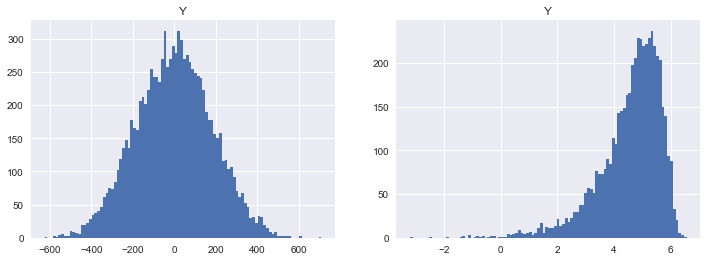

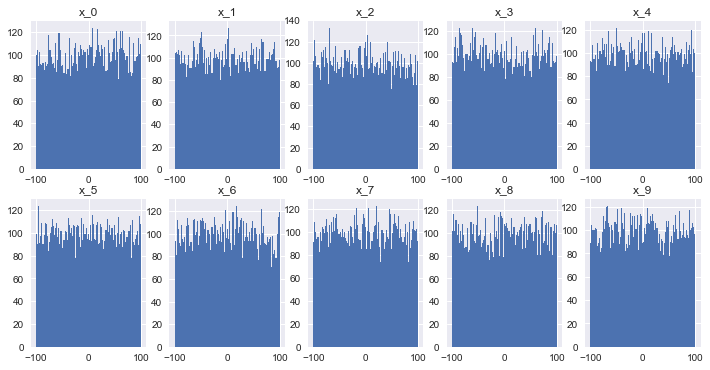

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(2, n_features/2, i+1)
    df['x_%i' % i].hist(bins=100)
    plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = b_i + \langle W_i, \mathbf x \rangle,
$$

In [12]:
import tensorflow as tf
tf.reset_default_graph()
from tf_bike.train import Trainer

In [32]:
def nn(x):    
    b = tf.Variable(tf.random_uniform(shape=(1,)), name='b')
    W = tf.Variable(tf.random_uniform(shape=(x.get_shape().as_list()[1], 1)), name='W') 
    return tf.add(b, tf.matmul(x, W), name='trivial_regression_model')

In [33]:
def np_loss(y_true, y_pred):
    return np.mean(np.mean(np.power(y_true - y_pred, 2.0), axis=-1))

def np_loss_array(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2.0), axis=-1)

def tf_loss(Y_true, Y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))

def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

In [34]:
tf.reset_default_graph()
y_true = np.ones((100, 1))
y_pred = np.linspace(-2, 2, num=100).reshape((100, 1))

lss = np_loss(y_true, y_pred)

with tf.Session() as sess:    
    Y_true = tf.placeholder(tf.float32, shape=(None, 1))
    Y_pred = tf.placeholder(tf.float32, shape=(None, 1))
    lss2, rmse = sess.run([tf_loss(Y_true, Y_pred), tf_rmse(Y_true, Y_pred)], feed_dict={Y_true: y_true, Y_pred: y_pred})

print("Loss numpy :", lss)
print("Loss tf :", lss2)
print("RMSE :", rmse)
    

Loss numpy : 2.36026936027
Loss tf : 2.36027
RMSE : 1.25758


In [36]:
training_params = {        
    # Network
    'network': nn,
    
    # Loss
    'loss': tf_loss,
    
    # Optimizer
    'optimizer': tf.train.GradientDescentOptimizer,
    
    # Metrics
    'metrics': [
        ('rmse', tf_rmse),
    ],
    
    # Learning rate params
    'lr': tf.train.piecewise_constant,
    'lr_kwargs': {
        'boundaries': [250, 350, 850],
        'values': [0.0001, 0.00006, 0.00001]
    },
    
    # Pretrained model
    # 'pretrained_model': 'best_from_logs',
    
    'training_epochs': 2500,
    'batch_size': 512,
    
    'seed': 2017,
    
}

In [48]:
from datetime import datetime
trainer = Trainer(log_dir='logs_{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M")))

In [49]:
trainer.train(trainval_x, trainval_y, 
              training_params=training_params, 
              verbose=1)

Start training
Model contains 2 of trainable variables and 11 of trainable parameters
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path logs_2017-06-30-13-18\train\Model/trivial_regression_model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch: 0100
loss=0.007095950 | rmse=0.083506941 
val_loss=0.007424986 | val_rmse=0.085459672 
Epoch: 0200
loss=0.006689183 | rmse=0.081077135 
val_loss=0.006999802 | val_rmse=0.082975529 
Epoch: 0300
loss=0.006305071 | rmse=0.078714075 
val_loss=0.006597372 | val_rmse=0.080553710 
Epoch: 0400
loss=0.005944459 | rmse=0.076429754 
val_loss=0.006220275 | val_rmse=0.078217655 
Epoch: 0500
loss=0.005605218 | rmse=0.074216606 
val_loss=0.005864827 | val_rmse=0.075949684 
Epoch: 0600
loss=0.005284105 | rmse=0.072058850 
val_loss=0.005528978 | val_rmse=0.073742665 
Epoch: 0700
loss=0.004979660 | rmse=0.069952143 
val_loss=0.005210804 | val_rmse=0.071589455 
Epoch: 0800
loss=0.004696123 | rmse=0.067930855 
val_loss=0.004914

In [19]:
training_params['pretrained_model'] = 'best_from_logs'

In [29]:
y_preds = trainer.predict(test_x, training_params=training_params, verbose=1)

Start predictions
INFO:tensorflow:Restoring parameters from logs_2017-06-30-12-35\Model\trivial_regression_model_seed=2017_loss=0.129069_val_loss=0.129036-2500
-- 0 / 20  | 0 - 512
-- 1 / 20  | 512 - 1024
-- 2 / 20  | 1024 - 1536
-- 3 / 20  | 1536 - 2048
-- 4 / 20  | 2048 - 2560
-- 5 / 20  | 2560 - 3072
-- 6 / 20  | 3072 - 3584
-- 7 / 20  | 3584 - 4096
-- 8 / 20  | 4096 - 4608
-- 9 / 20  | 4608 - 5120
-- 10 / 20  | 5120 - 5632
-- 11 / 20  | 5632 - 6144
-- 12 / 20  | 6144 - 6656
-- 13 / 20  | 6656 - 7168
-- 14 / 20  | 7168 - 7680
-- 15 / 20  | 7680 - 8192
-- 16 / 20  | 8192 - 8704
-- 17 / 20  | 8704 - 9216
-- 18 / 20  | 9216 - 9728
-- 19 / 20  | 9728 - 10000


In [30]:
lss = np_loss_array(test_y, y_preds)

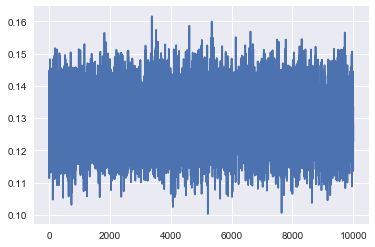

In [31]:
plt.plot(lss)

## A ratio-like and squared formula

Let $M=10$ and the function to learn is defined as 
$$
f(\mathbf x) = \frac{\sum_i a_i x_i + b} {\sum_i c_i x_i + d} + \alpha \sum_{i,j \neq i} x_i x_j + \beta
$$
where coefficients $a_i$, $b$, $c_i$, $d$, $\alpha$, $\beta$ are randomly chosen.

Setup input data :

In [107]:
import os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

n_samples = 10000
n_features = 10
a = np.random.rand(n_features)
b = 1.0
c = np.random.rand(n_features)
d = np.random.rand() * 100.0
alpha = np.random.rand() * 1.0 / 50.0
beta = np.random.rand() * 50.0

x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min
test_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [108]:
def f(sample_x):
    numerator = np.dot(a, sample_x) + b
    denominator = np.dot(c, sample_x) + d
    t1 = numerator / denominator
    
    t2 = 0
    for v in sample_x:
        t2 += v * (np.sum(sample_x) - v)    
    t2 *= alpha
    return t1 + t2 + beta

In [109]:
trainval_y = np.zeros((n_samples, 1))
test_y = np.zeros((n_samples, 1))

for i, x in enumerate(trainval_x):
    trainval_y[i] = f(x)
    
for i, x in enumerate(test_x):
    test_y[i] = f(x)    

In [110]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [111]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,18.908035,-65.778817,-76.054391,-66.212981,25.293067,19.119351,96.409735,57.607497,69.593030,-55.191581,-280.165355
1,-28.461742,62.323780,72.126596,85.355943,52.468099,-62.622827,24.144203,0.812550,-8.390462,31.654618,226.375988
2,-35.821878,44.524547,24.867569,36.366375,43.815772,-27.064073,67.136307,56.898283,9.977495,77.475432,548.374236
3,36.697332,-74.866707,-57.317503,90.349568,17.427056,80.388137,39.394559,-72.655997,-88.765190,45.267448,-327.751197
4,38.520690,-57.429805,81.155612,-42.665324,33.379119,-12.809968,49.171190,-53.091985,91.739268,-92.615075,-279.064649


In [126]:
y_min = df['y'].min()
y_max = df['y'].max()

def to_compact(y):
    return (y - y_min) / (y_max - y_min)    

def from_compact(y):
    return (y_max - y_min) * y + y_min

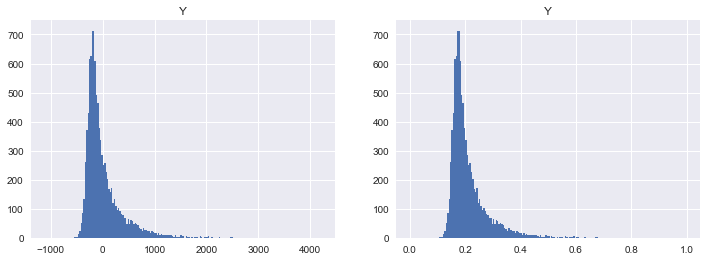

In [116]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=200)
plt.title('Y')
plt.subplot(122)
df['y'].apply(to_compact).hist(bins=200)
plt.title('Y')

# plt.figure(figsize=(12, 6))
# for i in range(n_features):
#     plt.subplot(2, n_features/2, i+1)
#     df['x_%i' % i].hist(bins=100)
#     plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = \prod_{i=0}^{k-1} \left( b_i + \langle W_i, g(\mathbf x) \rangle \right),
$$
where 
$$
g(\mathbf x) = g_m(\mathbf x) = h^{(1)}_{m,m-1}(\mathbf x) +  h^{(2)}_{m,m-1}\left(\frac{1}{\epsilon +\mathbf x}\right)
$$
and 
$$
h^{(i)}_{m,m-1}(\mathbf x) = \text{activation}(\langle W_{i,m}, g_{m-1}(\mathbf x) \rangle + b_{i,m}), \\
g_{0} (\mathbf x) = \mathbf x
$$


In [86]:
import tensorflow as tf
from tf_bike.train import Trainer
tf.reset_default_graph()

In [150]:
def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

def tf_loss(Y_true, Y_pred):
    l1 = tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))
    l2 = tf.log(1.0 + tf_rmse(Y_true, Y_pred))    
    return tf.minimum(l1, l2)

In [165]:
def h(index, m, x, n_filters, init_random=True, with_activation=True):    
    
    if init_random:
        b = tf.Variable(tf.random_uniform([n_filters]), 
                        name='bias_%i_%i' % (index, m))
    else:
        b = tf.Variable(tf.constant(1.0, shape=[n_filters]), 
                        name='bias_%i_%i' % (index, m))
    W = tf.Variable(tf.random_uniform(shape=[x.get_shape().as_list()[1], n_filters]), 
                    name="W_%i_%i" % (index, m))
        
    name = name='h_%i_%i' % (index, m)
    out = tf.add(tf.matmul(x, W), b)
    if with_activation:
        return tf.nn.elu(out, name=name)
    else:
        return tf.identity(out, name=name)
    
    
def g(m, x, n_filters_list):     
    assert len(n_filters_list) == m + 1, "n_filters_list should be of length m+1"
    epsilon = tf.constant(1e-10, name='eps')   
    _x = x if m == 0 else g(m-1, x, n_filters_list)
    h1 = h(1, m, _x, n_filters_list[m])
    h2 = h(2, m, tf.divide(tf.constant(1.0), tf.add(epsilon, _x)), n_filters_list[m], init_random=False)
    return tf.add(h1, h2, name='g_%i' % m)


def generic_nn(x, k, m, n_filters_lists):    
    assert k > 0, "Parameter k should be positive"
    assert m > 0, "Parameter m should be positive"
    n_filters_list = n_filters_lists[0]   
    temp_graphs = []
    
    
    subnets = [h(3, 0, g(m-1, x, n_filters_list), n_filters=1, with_activation=False), ]
    for i in range(1, k):
        n_filters_list = n_filters_lists[i]        
        subnets.append(tf.multiply(subnets[-1], h(3, 0, g(m-1, x, n_filters_list), n_filters=1, with_activation=False)))
    net = tf.identity(subnets[-1], name="net_%i_%i" % (k, m))
    return net
    
def nn(x):
    k = 1
    m = 2
    n_filters_lists = [
        [20, 20, 20, 20],
    ]
    return generic_nn(x, k=k, m=m, n_filters_lists=n_filters_lists)

In [180]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))

g_1 = g(1, X, [10, 10, 10])
g_2 = g(2, X, [10, 10, 10])

In [187]:
from tf_bike.visu import show_graph

graph = g_2.graph
graph_def = g_2.graph.as_graph_def()

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

show_graph(g_2.graph)

Number of layers 0
Total number of feature channels: 0


In [169]:
training_params = {        
    # Network
    'network': nn,
    
    # Loss
    'loss': tf_loss,
    
    # Optimizer
    'optimizer': tf.train.GradientDescentOptimizer,
    # 'optimizer': tf.train.AdadeltaOptimizer,
    
    # Metrics
    'metrics': [
        ('rmse', tf_rmse),
    ],
    
    # Learning rate params
    'lr': lambda x, **kwargs: tf.train.exponential_decay(global_step=x, **kwargs),
    'lr_kwargs': {
        'decay_steps': 100,
        'decay_rate': 0.9,
        'learning_rate': 0.01,
        'staircase': True
    },

#     'lr': tf.train.piecewise_constant, 
#     'lr_kwargs': {
#         'boundaries': [50, 100, 200, 500, 1000, ],
#         'values': [1e-3, 1e-4, 5*1e-5, 0.000001, 0.0000001]
#     },
    
    # Pretrained model
    # 'pretrained_model': 'best_from_logs',

    'training_epochs': 5000,
    'batch_size': 1024,
    
    'seed': 2017,
    
}

In [170]:
from datetime import datetime
trainer = Trainer(log_dir='logs_{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M")), display_step=50)

In [171]:
trainer.train(trainval_x, to_compact(trainval_y), 
              training_params=training_params, 
              verbose=1)

Start training
Model contains 10 of trainable variables and 1301 of trainable parameters
INFO:tensorflow:Restoring parameters from logs_2017-06-30-15-29\Model\net_1_2_seed=2017_loss=8.630745_val_loss=8.622858-24
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path logs_2017-06-30-15-29\train\Model/net_1_2.ckpt
INFO:tensorflow:Starting queue runners.
Epoch: 0050
loss=7.384137094 | rmse=2128.703742981 
val_loss=8.376173019 | val_rmse=4341.358886719 
Epoch: 0100
loss=7.666863024 | rmse=4130.558130264 
val_loss=9.618800163 | val_rmse=15043.992187500 
Epoch: 0150
loss=6.425857604 | rmse=681.560504913 
val_loss=7.979336739 | val_rmse=2918.993164062 
Epoch: 0200
loss=8.787738442 | rmse=6559.737060547 
val_loss=8.690260887 | val_rmse=5943.730468750 
Epoch: 0250
loss=6.909212112 | rmse=1137.864639282 
val_loss=5.635318279 | val_rmse=279.148010254 
Epoch: 0300
loss=6.074972361 | rmse=620.080210209 
val_loss=6.035618782 | val_rmse=417.057464600 
Epoch: 0350
loss=5

KeyboardInterrupt: 

In [172]:
training_params['pretrained_model'] = 'best_from_logs'

In [173]:
y_preds = trainer.predict(test_x, training_params=training_params, verbose=1)

Start predictions
INFO:tensorflow:Restoring parameters from logs_2017-06-30-15-29\Model\net_1_2_seed=2017_loss=1.888447_val_loss=1.975889-9912
-- 0 / 10  | 0 - 1024
-- 1 / 10  | 1024 - 2048
-- 2 / 10  | 2048 - 3072
-- 3 / 10  | 3072 - 4096
-- 4 / 10  | 4096 - 5120
-- 5 / 10  | 5120 - 6144
-- 6 / 10  | 6144 - 7168
-- 7 / 10  | 7168 - 8192
-- 8 / 10  | 8192 - 9216
-- 9 / 10  | 9216 - 10000


In [174]:
lss = np_loss_array(test_y[:100], from_compact(y_preds[:100]))

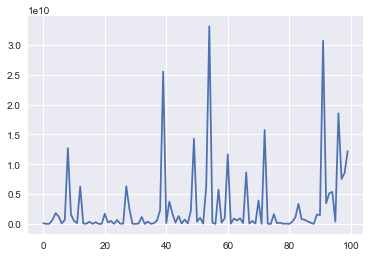

In [175]:
plt.plot(lss)

In [177]:
test_y[:10], y_preds[:10]

(array([[-111.67684002],
        [-354.29395427],
        [ -94.22359165],
        [-167.27725779],
        [-108.71277619],
        [-297.25644676],
        [-174.72413059],
        [ -67.40194646],
        [-135.8173416 ],
        [-156.45284048]]), array([[  2.234972  ],
        [ -0.3746472 ],
        [  1.16174889],
        [  5.14262581],
        [  8.18823051],
        [  6.82828903],
        [ -1.46647072],
        [  5.13165092],
        [-20.97135735],
        [ -7.27970314]]))